# Gaussian Process Regression

This demo shows how to use the GaussianProcessRegressor class to model the 
1-D dynamical system given by   
\begin{align}
y &= x \cos(x) \\
\frac{dy}{dx} &= \cos(x) - x \sin(x)
\end{align}

In [1]:
# Imports
import gpder
from gpder.gaussian_process import GaussianProcessRegressor
from gpder.gaussian_process.kernels import RegularKernel, DerivativeKernel

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Defining the function
def f(x):
    return x * np.cos(x)


# And the derivative -- to be used in the derivative GP regression
def df(x):
    return np.cos(x) - x * np.sin(x)

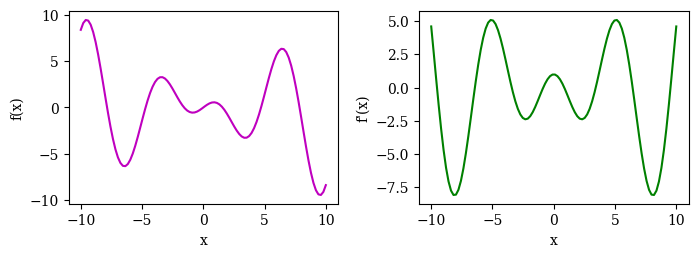

In [3]:
# -- Test dataset ---------------------------------------------------------- #
X_lower, X_upper = -10, 10
X_test = np.linspace(X_lower, X_upper, 100).reshape(-1, 1)
y_test = f(X_test)
dy_test = df(X_test)
# -------------------------------------------------------------------------- #

# -- Plotting -------------------------------------------------------------- #
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "10"
fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))
plt.subplots_adjust(wspace=0.3)
# Plotting the function
ax[0].plot(X_test, y_test, color="m")
ax[0].set_xlabel("x")
ax[0].set_ylabel("f(x)")
# And the gradients
ax[1].plot(X_test, dy_test, color="g")
ax[1].set_xlabel("x")
ax[1].set_ylabel("f'(x)")
plt.show()
# -------------------------------------------------------------------------- #

## Regular GP regression

Kernel: 
1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0)

Evaluation 
MSE:  18.90712481971354
Total variance:  65.05290914324675


/home/alex/Desktop/gpder_MLST/gpder/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


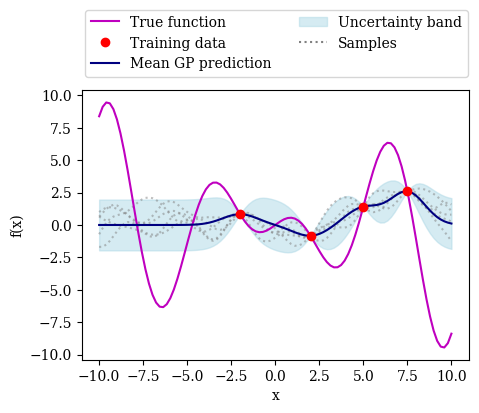

In [4]:
# -- Train dataset --------------------------------------------------------- #
X_train = np.array([-2, 2, 5, 7.5]).reshape(-1, 1)
y_train = f(X_train)
# -------------------------------------------------------------------------- #

# -- Fitting the model ----------------------------------------------------- #
kernel = RegularKernel(amplitude=1.0, length_scale=1.0, noise_level=None)
print("Kernel: ")
print(kernel)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp_reg.fit(X_train, y_train)
# -------------------------------------------------------------------------- #

# -- Prediction and eval --------------------------------------------------- #
y_pred_mean, y_pred_std = gp_reg.predict(X_test, return_std=True)
samples = gp_reg.sample(X_test, n_draws=5, random_state=42)

print("\nEvaluation ")
mse = np.sum((y_test - y_pred_mean) ** 2) / len(y_test)
print("MSE: ", mse)
print("Total variance: ", np.sum(y_pred_std**2))
# -------------------------------------------------------------------------- #

# -- Plotting -------------------------------------------------------------- #
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "10"
plt.figure(figsize=(5, 3.5))
plt.plot(X_test, y_test, label="True function", color="m", zorder=3)
plt.plot(X_train, y_train, "o", label="Training data", color="#FF0000", zorder=4)
plt.plot(X_test, y_pred_mean, label="Mean GP prediction", color="navy", zorder=3)
plt.fill_between(
    X_test.ravel(),
    y_pred_mean.ravel() - 1.96 * y_pred_std.ravel(),
    y_pred_mean.ravel() + 1.96 * y_pred_std.ravel(),
    color="lightblue",
    alpha=0.5,
    zorder=1,
    label="Uncertainty band",
)
for sample in samples:
    plt.plot(X_test, sample, color="gray", alpha=0.5, zorder=2, ls="dotted")
plt.plot([0], [0], color="gray", linestyle="dotted", label="Samples")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(ncol=2, loc=(0.01, 1.05))
plt.show()
# -------------------------------------------------------------------------- #

# Derivative GP regression

We use the same hyperparameters used in the regular GP regression.

Kernel: 
1**2 * DerivativeRBF(length_scale=1) + WhiteKernel(noise_level=0) + WhiteKernel_der(noise_level=0)

Evaluation 
MSE:  13.145762403994592
Total variance:  49.14995693603309


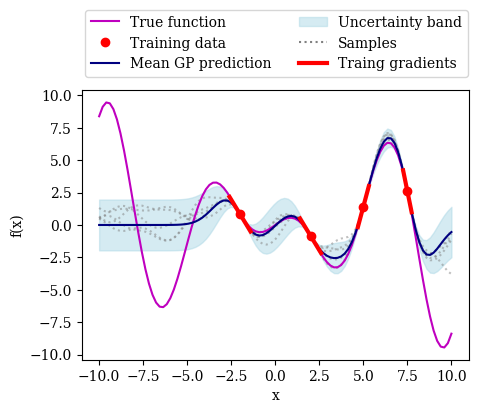

In [5]:
# -- Gradients ------------------------------------------------------------- #
dX_train = X_train
dy_train = df(dX_train)
# -------------------------------------------------------------------------- #

# -- Fitting the derivative model ------------------------------------------ #
kernel = DerivativeKernel(amplitude=1.0, length_scale=1.0, noise_level=None, noise_level_der=None)
print("Kernel: ")
print(kernel)
gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None)
# when fitting the model, we include the gradients
gp_der.fit(X_train, y_train, dX=dX_train, dy=dy_train)
# -------------------------------------------------------------------------- #

# -- Prediction and eval --------------------------------------------------- #
y_pred_mean, y_pred_std = gp_der.predict(X_test, return_std=True)
samples = gp_der.sample(X_test, n_draws=5, random_state=42)

print("\nEvaluation ")
mse = np.sum((y_test - y_pred_mean) ** 2) / len(y_test)
print("MSE: ", mse)
print("Total variance: ", np.sum(y_pred_std**2))
# -------------------------------------------------------------------------- #


# -- Plotting -------------------------------------------------------------- #
def yinline(x, m, b):
    return m * x + b


def xincircle(x0, y0, m, b, r):
    A = 1 + m**2
    B = 2 * (m * b - x0 - y0 * m)
    C = x0**2 + y0**2 + b**2 - 2 * y0 * b - r**2
    res_plus = (-B + np.sqrt(B**2 - 4 * A * C)) / (2 * A)
    res_neg = (-B - np.sqrt(B**2 - 4 * A * C)) / (2 * A)
    return np.array((res_plus, res_neg))


def xinelipse(x0, y0, m, b, rx, ry):
    A = 1 / rx**2 + m**2 / ry**2
    B = 2 * (m * (b - y0) / ry**2 - x0 / rx**2)
    C = x0**2 / rx**2 + (b - y0) ** 2 / ry**2 - 1
    res_plus = (-B + np.sqrt(B**2 - 4 * A * C)) / (2 * A)
    res_neg = (-B - np.sqrt(B**2 - 4 * A * C)) / (2 * A)
    return np.array((res_plus, res_neg))


def get_gradients_xy(x, y, dy, length_x, length_y=None):
    b = y - dy * x
    if length_y is None:
        x_vals = xincircle(x, y, dy, b, length_x)
    else:
        x_vals = xinelipse(x, y, dy, b, length_x, length_y)
    y_vals = np.array([yinline(x_vals[0], dy, b), yinline(x_vals[1], dy, b)])
    return (x_vals, y_vals)


plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "10"
plt.figure(figsize=(5, 3.5))
plt.plot(X_test, y_test, label="True function", color="m", zorder=3)
plt.plot(X_train, y_train, "o", label="Training data", color="#FF0000", zorder=4)
plt.plot(X_test, y_pred_mean, label="Mean GP prediction", color="navy", zorder=3)
plt.fill_between(
    X_test.ravel(),
    y_pred_mean.ravel() - 1.96 * y_pred_std.ravel(),
    y_pred_mean.ravel() + 1.96 * y_pred_std.ravel(),
    color="lightblue",
    alpha=0.5,
    zorder=1,
    label="Uncertainty band",
)
for sample in samples:
    plt.plot(X_test, sample, color="gray", alpha=0.5, zorder=2, ls="dotted")
for x, y, dy in list(zip(X_train, y_train, dy_train)):
    x_vals, y_vals = get_gradients_xy(x, y, dy, 1, 1 * (5 / 3))
    plt.plot(x_vals, y_vals, color="#FF0000", lw=3, zorder=5)
plt.plot([0], [0], color="gray", linestyle="dotted", label="Samples")
plt.plot([0], [0], color="#FF0000", lw=3, label="Traing gradients")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(ncol=2, loc=(0.01, 1.05))
plt.show()
# -------------------------------------------------------------------------- #

The error and total variance of the model decreases significantly when including derivative information.   
In additionn, we see how the gradients help the model learn more efficiently the inflection and turning points.